In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [95]:
df=pd.read_csv("india_menu.csv")
df.head()

,Menu Category,Menu Items,Per Serve Size,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg)
0,Regular Menu,McVeggie™ Burger,168 g,402.05,10.24,13.83,5.34,0.16,2.49,56.54,7.90,4.49,706.13
1,Regular Menu,McAloo Tikki Burger®,146 g,339.52,8.50,11.31,4.27,0.20,1.47,50.27,7.05,4.07,545.34
2,Regular Menu,McSpicy™ Paneer Burger,199 g,652.76,20.29,39.45,17.12,0.18,21.85,52.33,8.35,5.27,1074.58
3,Regular Menu,Spicy Paneer Wrap,250 g,674.68,20.96,39.10,19.73,0.26,40.93,59.27,3.50,1.08,1087.46
4,Regular Menu,American Veg Burger,177 g,512.17,15.30,23.45,10.51,0.17,25.24,56.96,7.85,4.76,1051.24


# EDA

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Menu Category           141 non-null    object 
 1   Menu Items              141 non-null    object 
 2   Per Serve Size          141 non-null    object 
 3   Energy (kCal)           141 non-null    float64
 4   Protein (g)             141 non-null    float64
 5   Total fat (g)           141 non-null    float64
 6   Sat Fat (g)             141 non-null    float64
 7   Trans fat (g)           141 non-null    float64
 8   Cholesterols (mg)       141 non-null    float64
 9   Total carbohydrate (g)  141 non-null    float64
 10  Total Sugars (g)        141 non-null    float64
 11  Added Sugars (g)        141 non-null    float64
 12  Sodium (mg)             140 non-null    float64
dtypes: float64(10), object(3)
memory usage: 14.4+ KB


In [97]:
# lets see if clustering of menu items gives us meaningful insights are not
# order of proceeding multicollinearity check--> pca--> clsutering

### Null value check

In [98]:
# checking for null values
df.isnull().sum()

Menu Category             0
Menu Items                0
Per Serve Size            0
Energy (kCal)             0
Protein (g)               0
Total fat (g)             0
Sat Fat (g)               0
Trans fat (g)             0
Cholesterols (mg)         0
Total carbohydrate (g)    0
Total Sugars (g)          0
Added Sugars (g)          0
Sodium (mg)               1
dtype: int64

In [99]:
# highly skewed sodium column
df["Sodium (mg)"].skew()

1.8535602180021005

In [100]:
df["Sodium (mg)"].median()

152.025

In [101]:
# median imputation
df["Sodium (mg)"].fillna(df["Sodium (mg)"].median(), inplace=True)

In [102]:
# converting into numeric column - per serve size
df["Per Serve Size"]

0       168 g
1       146 g
2       199 g
3       250 g
4       177 g
        ...  
136       8 g
137      30 g
138      14 g
139      40 g
140    180 ml
Name: Per Serve Size, Length: 141, dtype: object

In [103]:
def split(x):
    x=x.split(" ")
    return float(x[0])
split("40 g")

40.0

In [104]:
df["Per_Serve_Gms"]=df["Per Serve Size"].apply(split)

In [105]:
df["Sodium (mg)"]

0       706.13
1       545.34
2      1074.58
3      1087.46
4      1051.24
        ...   
136      71.05
137      15.00
138     178.95
139       0.04
140      10.80
Name: Sodium (mg), Length: 141, dtype: float64

In [106]:
# converting sodium column to float
df["Sodium (mg)"]=df["Sodium (mg)"].astype(float)
df["Per_Serve_Gms"]=df["Per_Serve_Gms"].astype(float)

In [107]:
df["Sodium (mg)"].isnull().sum()

0

In [108]:
# CHECKPOINT 1
df_1=df.copy()

In [109]:
# dropping Menu Items as this column contains the dish name, which is unique for each row
df_fin=df.drop("Menu Items",axis=1)
# dropping per serve size column which is replaced by Per_Serve_Gms 
df_fin.drop("Per Serve Size",axis=1,inplace=True)

In [110]:
# splitting category and numeric features into separate frames
df_num=df_fin.select_dtypes(include=np.number)
df_cat=df_fin.select_dtypes(include="object")

<AxesSubplot:>

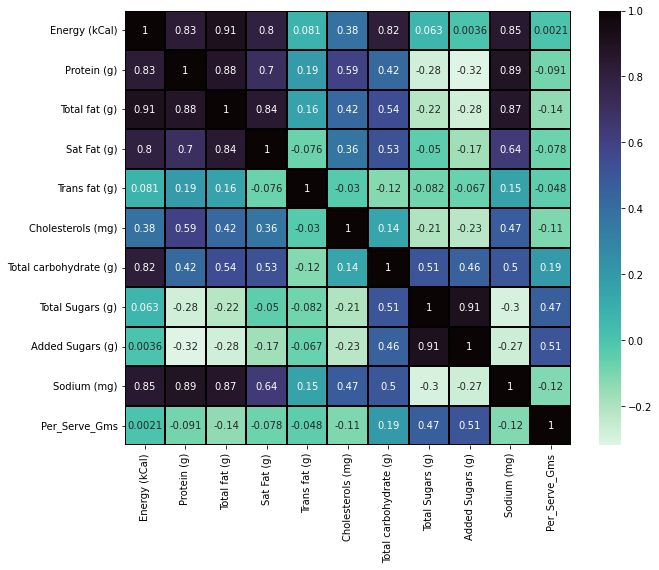

In [111]:
# multicollinearity check for numerical columns using heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_num.corr(),annot=True,linecolor='black',linewidths="0.1",cmap='mako_r')

In [112]:
# we can see that some of the columns are co-related with each other
# this tells us there is need of dropping of columns based on VIF scores

In [113]:
#lets check the VIF scores

df_vif=pd.DataFrame()

df_vif["vif_scores"]=[variance_inflation_factor(df_num.values,i) for i in range(df_num.shape[1])]

df_vif["features"]=df_num.columns


In [114]:
df_vif

,vif_scores,features
0,426.877554,Energy (kCal)
1,29.623496,Protein (g)
2,48.015688,Total fat (g)
3,13.500205,Sat Fat (g)
4,1.864479,Trans fat (g)
5,2.304190,Cholesterols (mg)
6,151.226999,Total carbohydrate (g)
7,19.224729,Total Sugars (g)
8,11.581862,Added Sugars (g)
9,15.870724,Sodium (mg)


In [115]:
#dropping energy,Total Sugars and total fat based on the vif scores
df_num.drop(["Energy (kCal)","Total fat (g)","Total Sugars (g)"],axis=1,inplace=True)

<AxesSubplot:>

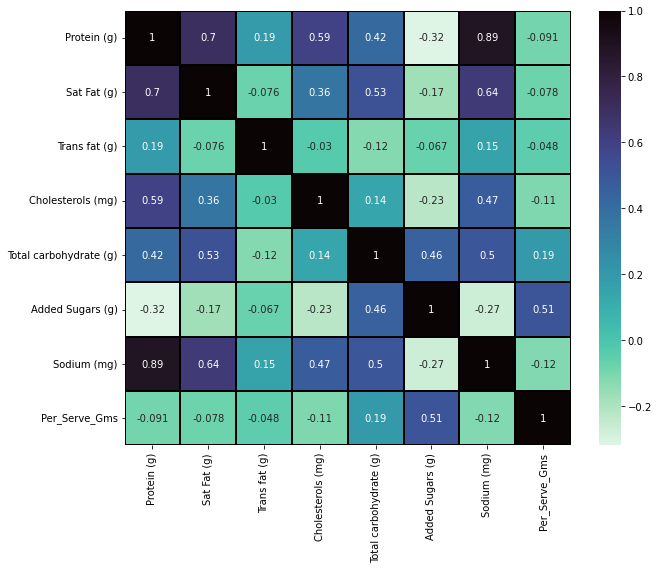

In [116]:
# multicollinearity check for numerical columns using heatmap after treatment
plt.figure(figsize=(10,8))
sns.heatmap(df_num.corr(),annot=True,linecolor='black',linewidths="0.1",cmap='mako_r')
plt.show()

In [ ]:
# from domain knowledge we can intrepret sodium and protien are actually not interrelated to each 
# other, eventhough corelation factor says that they are
# hence we are not, removing any of the two columns and proceeding with kmeans clustering

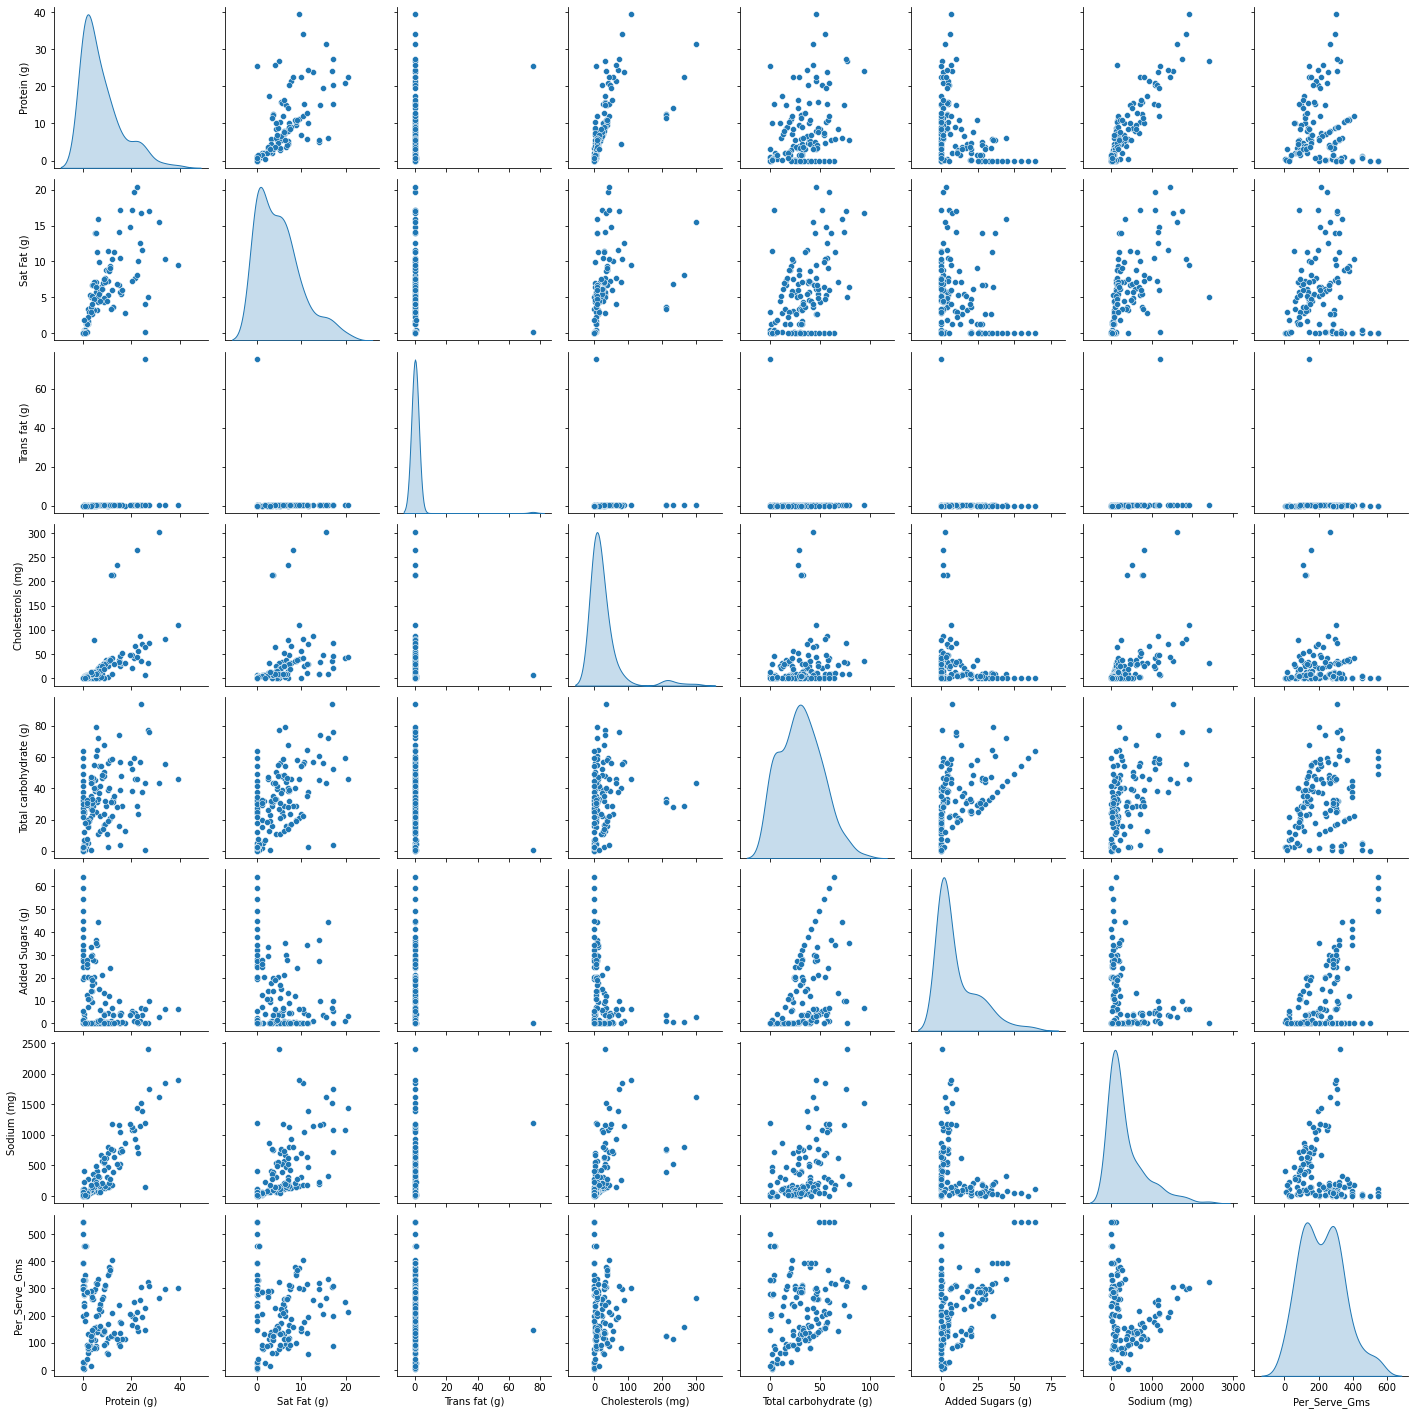

In [118]:
# pairplot visualization to find the association
sns.pairplot(data=df_num,diag_kind="kde")

# Machine learning model building

In [ ]:
# for Kmeans clustering we need to find optimal value of n_clusters
# to do so we will use scree plot and sillhoutte scores method
# first we shall calculate inertia values for various number of clusters in range 1 to 40

In [122]:
wcss = []
for i in range(1,40,2):
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(df_num)
    wcss.append(kmeans.inertia_)

In [123]:
wcss

[33800290.5786078,
 5910500.051384419,
 2901633.7810873967,
 1951099.3176431062,
 1326873.0808156494,
 984507.5089579748,
 813866.3780254383,
 669200.9615759394,
 570101.2472322687,
 470128.31376383564,
 414245.1192376334,
 349382.59064024827,
 314716.6256560265,
 294595.78496939165,
 261287.38199140792,
 238754.79390740008,
 203184.6867854762,
 186513.4232575687,
 172470.61009331272,
 157699.21886012823]

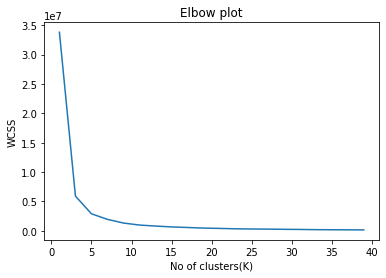

In [124]:
# elbow plot to identify the k value with inertia breakpoint
plt.plot(range(1,40,2),wcss)
plt.title("Elbow plot")
plt.xlabel("No of clusters(K)")
plt.ylabel("WCSS")
plt.show()

In [125]:
# higher resolution elbow plot in the range 1 to 15
wcss = []
for i in range(1,15,1):
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(df_num)
    wcss.append(kmeans.inertia_)

In [126]:
wcss

[33800290.5786078,
 10965165.363344235,
 5910500.051384419,
 4128397.7061687103,
 2901633.7810873967,
 2327516.5777041446,
 1951099.3176431062,
 1618727.2808525446,
 1326873.0808156494,
 1139864.4262172654,
 984507.5089579748,
 882144.7362629225,
 813866.3780254383,
 733974.749471951]

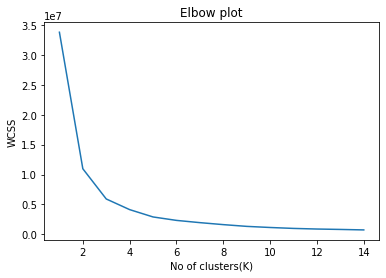

In [127]:
# elbow plot to identify the k value in range 1 to 15
plt.plot(range(1,15,1),wcss)
plt.title("Elbow plot")
plt.xlabel("No of clusters(K)")
plt.ylabel("WCSS")
plt.show()

In [ ]:
# from above plot we can identify that the at elbow point n_clusters is 3
# re-assuring with silhoutte scores

In [131]:
sc = []
for k in range(2,15):
    clusters = KMeans(n_clusters=k, random_state=10)
    labels = clusters.fit_predict(df_num)
    score = silhouette_score(df_num,labels,random_state=10)
    sc.append(score)

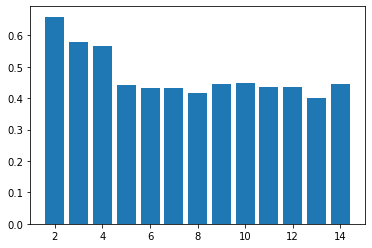

In [133]:
plt.bar(range(2,15), sc)
plt.show()

In [ ]:
# eventhough initial drop at n_clusters =2, we choose optimum number of clusters as 3 as the rate 
# of steepness is declining more after this point

In [159]:
# building our final model
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(df_num)
label = kmeans3.labels_
centroids=kmeans3.cluster_centers_

In [160]:
# evaluating groupings of the clusters, count
pd.DataFrame(label).value_counts()

0    95
2    29
1    17
dtype: int64

In [161]:
df_fin["cluster_label"]=label

In [163]:
df_fin.head(10)

,Menu Category,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg),Per_Serve_Gms,cluster_label
0,Regular Menu,402.05,10.24,13.83,5.34,0.16,2.49,56.54,7.90,4.49,706.13,168.0,2
1,Regular Menu,339.52,8.50,11.31,4.27,0.20,1.47,50.27,7.05,4.07,545.34,146.0,2
2,Regular Menu,652.76,20.29,39.45,17.12,0.18,21.85,52.33,8.35,5.27,1074.58,199.0,1
3,Regular Menu,674.68,20.96,39.10,19.73,0.26,40.93,59.27,3.50,1.08,1087.46,250.0,1
4,Regular Menu,512.17,15.30,23.45,10.51,0.17,25.24,56.96,7.85,4.76,1051.24,177.0,1
5,Regular Menu,832.67,24.17,37.94,16.83,0.28,36.19,93.84,11.52,6.92,1529.22,306.0,1
6,Regular Menu,356.09,7.91,15.08,6.11,0.24,9.45,46.36,4.53,1.15,579.60,132.0,2
7,Regular Menu,228.21,5.45,11.44,5.72,0.09,5.17,24.79,2.73,0.35,390.74,87.0,2
8,Regular Menu,400.80,15.66,15.70,5.47,0.16,31.17,47.98,5.53,4.49,766.33,173.0,2
9,Regular Menu,348.11,15.44,14.16,5.79,0.21,32.83,38.85,5.58,3.54,530.54,136.0,2


In [164]:
df_fin.groupby('cluster_label').mean()

,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg),Per_Serve_Gms
cluster_label,,,,,,,,,,,
0,162.400737,3.351895,5.131579,3.276105,0.145158,10.023684,26.504000,20.367158,13.972000,95.420368,248.774737
1,612.428235,23.693529,31.680588,12.270000,4.637647,62.942941,54.721765,8.139412,4.527647,1416.635882,238.705882
2,298.422414,11.564483,13.198621,6.373793,0.146897,58.382069,32.747586,3.700000,1.834483,610.112414,125.324138


In [143]:
# we can see there is definite diference in means of all the features among the clusters
# this indicate that the data is clustered well
# we will follow up by evaluating each groups

<Figure size 1440x1080 with 0 Axes>

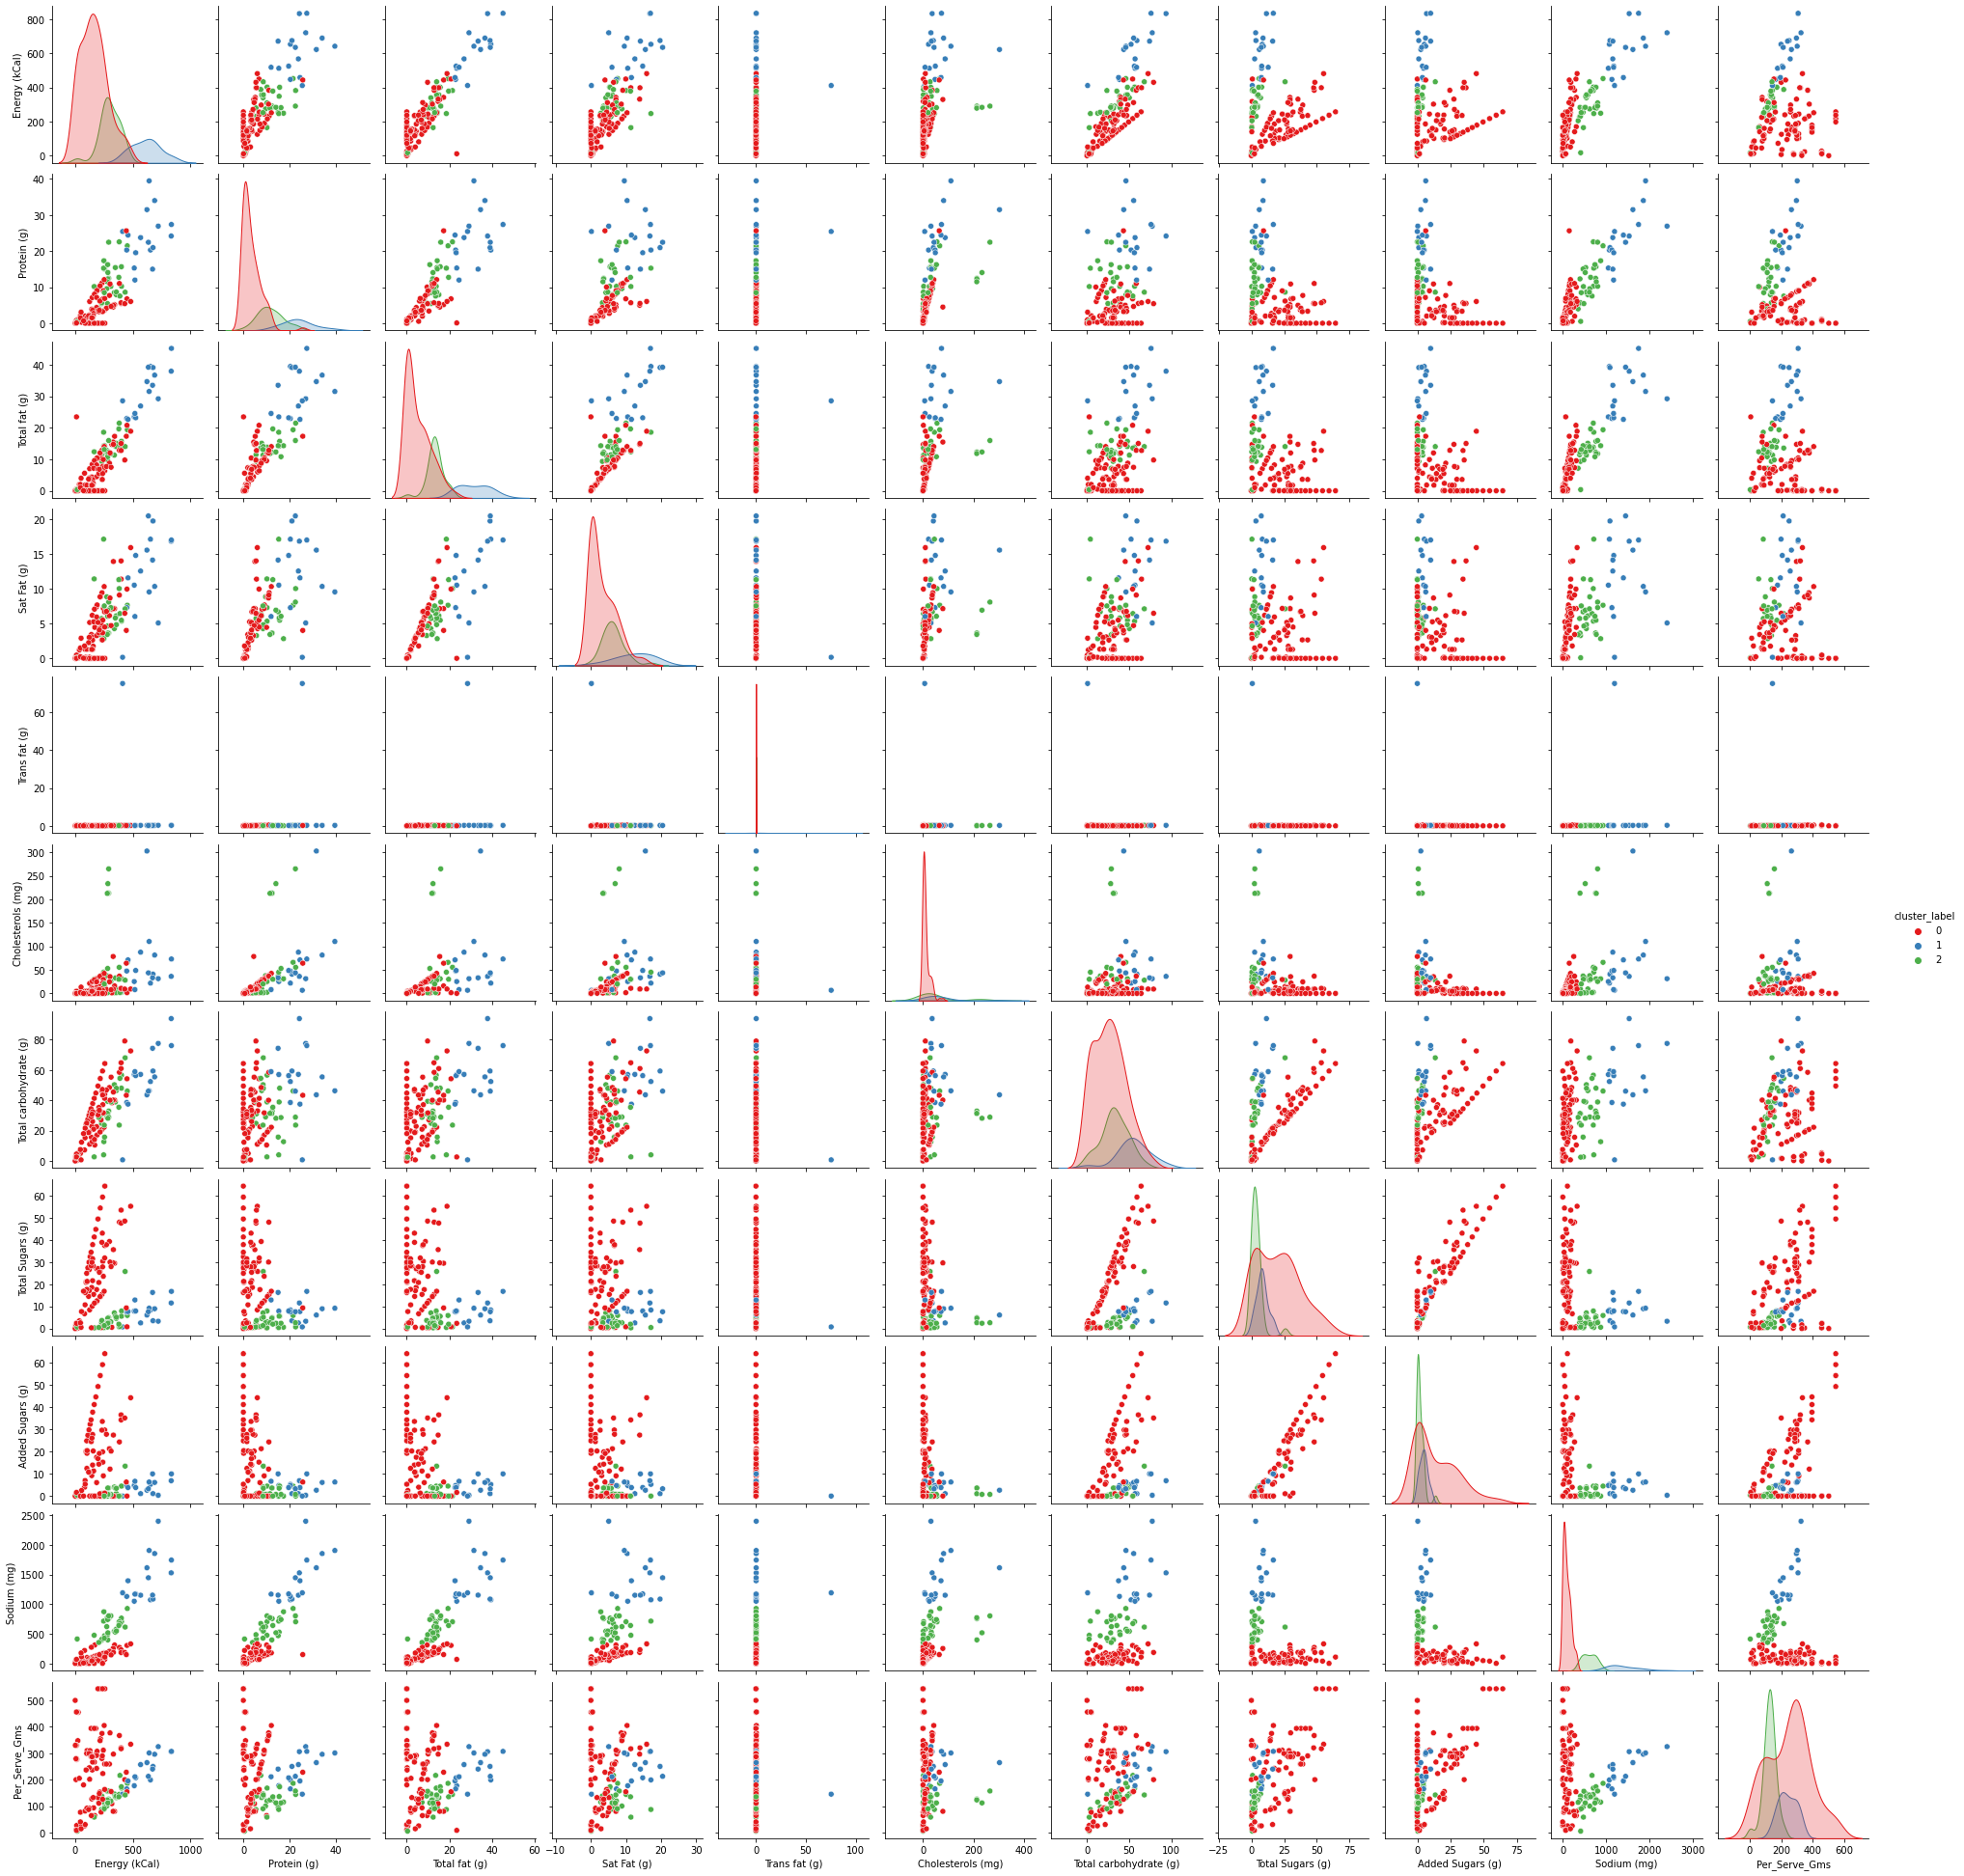

In [165]:
plt.figure(figsize=(20,15))
sns.pairplot(data=df_fin.iloc[:,1:],diag_kind="kde",hue="cluster_label",palette="Set1")
plt.show()

In [166]:
g1=df_fin[df_fin["cluster_label"]==0]
g2=df_fin[df_fin["cluster_label"]==1]
g3=df_fin[df_fin["cluster_label"]==2]

In [167]:
pd.crosstab(columns=df_fin["Menu Category"],index=df_fin["cluster_label"])

Menu Category,Beverages Menu,Breakfast Menu,Condiments Menu,Desserts Menu,Gourmet Menu,McCafe Menu,Regular Menu
cluster_label,,,,,,,
0,17,8,8,2,1,51,8
1,0,0,0,0,8,0,9
2,0,7,1,0,2,0,19


In [168]:
# we can see Bevarage drinks, McCafe dishes are both clustered into same clusters completely
# hence beverages and drinks are grouped together
g1.describe()

,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg),Per_Serve_Gms,cluster_label
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.00000,95.000000,95.000000,95.0
mean,162.400737,3.351895,5.131579,3.276105,0.145158,10.023684,26.504000,20.367158,13.97200,95.420368,248.774737,0.0
std,118.776366,4.071480,5.799625,3.775400,0.135841,14.289451,19.010481,16.729379,16.06907,86.102313,135.974938,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,8.000000,0.0
25%,76.715000,0.265000,0.070000,0.045000,0.040000,0.350000,10.760000,2.415000,0.00000,23.190000,132.080000,0.0
50%,150.850000,1.990000,3.570000,1.740000,0.110000,4.700000,25.180000,18.530000,9.12000,70.260000,276.500000,0.0
75%,233.815000,5.275000,8.585000,5.715000,0.230000,11.510000,40.085000,29.920000,25.25000,152.587500,330.000000,0.0
max,481.110000,25.630000,23.450000,15.910000,0.470000,78.520000,79.040000,64.220000,64.22000,332.600000,544.000000,0.0


In [ ]:
# group 1 has the highest mean for total and added sugars
# however this group is least caloric dense among other groupings
# nutrition and fat profile also low for this group

In [169]:
#adding sish names to final frame
df_fin["Menu Items"]=df["Menu Items"]

In [171]:
# regrouping according to cluster labels
g1=df_fin[df_fin["cluster_label"]==0]
g2=df_fin[df_fin["cluster_label"]==1]
g3=df_fin[df_fin["cluster_label"]==2]

In [174]:
g1["Menu Items"].unique()

array(['4 piece Chicken McNuggets', 'Regular Fries', 'Medium Fries',
       'Large Fries', 'L1 Coffee', 'L1 Coffee with milk',
       'Double Chocochips Muffin', 'Vanilla Chocochips Muffin',
       'Hash Brown', 'Espresso', 'Espresso Machiato', 'Americano (S)',
       'Americano (R)', 'Americano (L)', 'Cappuccino (S)',
       'Cappuccino (R)', 'Cappuccino (L)', 'Latte (S)', 'Latte (R)',
       'Latte (L)', 'Flat White (S)', 'Flat White (R)', 'Flat White (L)',
       'Mocha (S)', 'Mocha (R)', 'Mocha (L)', 'Babycino',
       'Hot Chocolate (S)', 'Hot Chocolate (R)', 'Hot Chocolate (L)',
       'Premium Dark Hot Chocolate', 'Double Dark Hot Chocolate',
       'English Breakfast (S)', 'English Breakfast (R)',
       'English Breakfast (L)', 'Moroccon Mint Green Tea (S)',
       'Moroccon Mint Green Tea (R)', 'Moroccon Mint Green Tea (L)',
       'Strawberry Green Tea (S)', 'Strawberry Green Tea (R)',
       'Strawberry Green Tea (L)', 'Lemon Ice Tea', 'Strawberry Ice Tea',
       'Green Ap

In [ ]:
# we can see in addition to beverages sauce items and cheese slice, sweet corn fall in first cluster
# ['English Breakfast (S)', 'English Breakfast (R)','English Breakfast (L)'] are excellent breakfast
# option for people who are calorie conscious or in a diet

In [175]:
# analyzing 2nd cluster
g2["Menu Items"].unique()

array(['McSpicy™ Paneer Burger', 'Spicy Paneer Wrap',
       'American Veg Burger', 'Veg Maharaja Mac', 'Spicy Chicken Wrap',
       'Chicken Maharaja Mac', 'American Chicken Burger',
       'Ghee Rice with Mc Spicy Fried Chicken 1 pc',
       '5 piece Chicken Strips', 'American Triple Cheese Chicken',
       'American Triple Cheese Veg', 'Cheese Lava Burger',
       'Chicken Cheese Lava Burger',
       'Chunky Chipotle American Burger Chicken',
       'McSpicy Premium Chicken Burger', 'McSpicy Premium Veg Burger',
       'Piri piri Mc Spicy Veg Burger'], dtype=object)

In [176]:
# foods with high panneer, cheese, ghee are grouped into this cluster
# we can also see the most of the burger, wraps fell into this cluster
g2.describe()

,Energy (kCal),Protein (g),Total fat (g),Sat Fat (g),Trans fat (g),Cholesterols (mg),Total carbohydrate (g),Total Sugars (g),Added Sugars (g),Sodium (mg),Per_Serve_Gms,cluster_label
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0
mean,612.428235,23.693529,31.680588,12.270000,4.637647,62.942941,54.721765,8.139412,4.527647,1416.635882,238.705882,1.0
std,124.034048,6.967162,7.154920,5.519664,18.199022,68.001788,20.443416,4.422572,3.007149,379.676492,55.282812,0.0
min,411.090000,11.970000,22.650000,0.150000,0.150000,6.700000,0.730000,0.720000,0.000000,1051.240000,145.000000,1.0
25%,517.980000,20.290000,24.530000,9.540000,0.180000,31.320000,46.000000,6.070000,2.640000,1152.380000,199.000000,1.0
50%,634.710000,23.740000,31.510000,12.540000,0.240000,43.680000,56.240000,7.850000,4.760000,1193.050000,240.000000,1.0
75%,674.680000,26.910000,37.940000,16.830000,0.270000,73.110000,59.270000,9.160000,6.320000,1614.880000,296.000000,1.0
max,834.360000,39.470000,45.180000,20.460000,75.260000,302.610000,93.840000,16.750000,10.010000,2399.490000,325.000000,1.0


In [ ]:
# group 2 is most caloric dense among 3 clusters
# this group also contains the most Trans Fat and Sodim content
# based on our domain knowledge we can easily say dishes in this group are not so 
# healthy choice for the heart
# AS sodium increases blood pressure, Transfat raises bad_cholestrol level 

In [177]:
# analyzing 3rd cluster
g3["Menu Items"].unique()

array(['McVeggie™ Burger', 'McAloo Tikki Burger®',
       'Green Chilli Aloo Naan', 'Pizza Puff', 'Mc chicken Burger',
       'FILLET-O-FISH Burger', 'Mc Spicy Chicken Burger',
       'Chicken Kebab Burger', 'Green Chilli Kebab naan',
       'Mc Egg Masala Burger', 'Mc Egg Burger for Happy Meal',
       'McSpicy Fried Chicken 1 pc', '6 piece Chicken McNuggets',
       '9 piece Chicken McNuggets', '2 piece Chicken Strips',
       '3 piece Chicken Strips', 'Regular Wedges', 'Medium Wedges',
       'Large Wedges', 'Veg McMuffin', 'Double Cheese McMuffin',
       'Spicy Egg McMuffin', 'Sausage Mc Muffin',
       'Sausage Mc Muffin with egg', 'Egg McMuffin',
       'Hot Cake with maple syrup', 'Cheesy Veg Nuggets (6pc)',
       'Cheesy Veg Nuggets (9pc)', 'Piri Piri Mix'], dtype=object)

In [ ]:
# we can see most of the muffin dishes are grouped into this cluster
# chicken Nuggets,strips and potato wedges are also common in this group
# we can see only desert in this cluster is Hot Cake with Maple syrup
# the dishes in this good alternative for those in group 2 
# However, the average serving size of this group is almost half of group 2, indicating that
# when equal quantity of food from group 2 and group 3 are eaten, they almost have same nutrient profile
# difference only being low Trans-fat

In [ ]:
# Hence based on Trans-Fat content we can say group-3 dishes are healthier choice in general when
# compared to group 2 dishes
# since , they have half the serving size of their group 2 counter-parts, they can also potentially
# promote less food wastage simultaneously reducing food consumption by an individual.

## Food Recommender engine (based on health inferences above)

In [ ]:
# this reommender engine aims to readuce transfat and sodim to least, while keeping cap for calories per combo within 600 kcal

In [179]:
t1=g1["Menu Items"].unique().tolist()
t2=g2["Menu Items"].unique().tolist()
t3=g3["Menu Items"].unique().tolist()

In [208]:
combo=int(input("Enter number of dishes required for combo: 2,3,4 :"))
for i in range(1,10000):
    l1=[]
    count=0
    sum_cal=0
    for i in range(1,100):
        k=np.random.choice(t1,size=1)[0]
        b=np.random.choice(t2,size=1)[0]
        if k not in l1:
            l1.append(k)
            count=count+1
        if b not in l1:
            l1.append(b)
            count=count+1
        if count==combo:
            break;
    for n in l1:
        cal=df_fin[df_fin["Menu Items"]==n]["Energy (kCal)"].values[0]
        sum_cal=sum_cal+cal
    if sum_cal<=600:
        print("I've Found a healthier combo, please try it!!!")
        print("It contains",round(sum_cal,2),"Kcal of calories which fall inside of 600/meal cap")
        print(l1)
        break;
    elif sum_cal>600:
        continue;

Enter number of dishes required for combo: 2,3,4 :3
I've Found a healthier combo, please try it!!!
It contains 476.27 Kcal of calories which fall inside of 600/meal cap
['Americano (R)', 'American Chicken Burger', 'Moroccon Mint Green Tea (S)']
